In [1]:
from sympy import symbols, poly, Sum, Indexed, sympify, Poly, Lambda, Derivative, Function, Subs, lambdify, DiracDelta, series
from sympy.functions import sign, Abs
import numpy as np
from scipy.special import gamma, factorial
import pandas as pd

In [2]:
x, y, z, p, s, t = symbols("x y z p s t", real = True)

In [3]:
M = 6
v = symbols(f"v:{M}", real = True)
v_sub = symbols(f"v_sub:{M}", real = True)
d, g = symbols("delta gamma", real = True)
f = Lambda(x, x ** d)
f_dev = Lambda(x, d * x ** (d - 1))
poly_p = Poly(v[::-1], p)
poly_p_sub = Poly(v_sub[::-1], p)
v_func = poly_p.expr
v_sub_func = poly_p_sub.expr
F_first = Lambda(p, f(v_func))
F_second = Lambda(p, v_func * f_dev(v_sub_func))

In [5]:
h = -50.0
N = 50
gamma_const = 0.5
delta_const = 0.5
T = 1
X = 0.1
G = np.zeros((N, N))

def G_ij_upper(i, j):
    return (1 / (1 - gamma_const) * (1 - gamma_const)) * (T / N) ** (2 - gamma_const) \
            * ((i - j + 1) ** (2 - gamma_const) - 2 * (i - j) ** (2 - gamma_const) +\
                 (i - j - 1) ** (2 - gamma_const)) 

def G_ii_diagonal():
    return (2 / ((1 - gamma_const) * (2 - gamma_const))) * (T / N) ** (2 - gamma_const)
    
G_upper = np.fromfunction(G_ij_upper, (N, N))
G_upper = np.nan_to_num(G_upper, nan = 0.0)
G_diag = np.repeat(G_ii_diagonal(), N)
G_diag = np.diag(G_diag)
G = G_upper.T + G_upper + G_diag

v_guess = np.repeat(T * X / N, N) ## VWAP

<ipython-input-5-1aec47da35a1>:11: RuntimeWarning: invalid value encountered in power
  * ((i - j + 1) ** (2 - gamma_const) - 2 * (i - j) ** (2 - gamma_const) +\
<ipython-input-5-1aec47da35a1>:12: RuntimeWarning: invalid value encountered in power
  (i - j - 1) ** (2 - gamma_const))


In [6]:
def gss_guess(t: np.array) -> np.array:
    gamma_1 = gamma((1 + gamma_const)/ 2)
    gamma_2 = gamma(1 + (gamma_const / 2))
    c = (X / N) / (np.sqrt(np.pi) * (T / 2) ** gamma_const * (gamma_1 / gamma_2))
    return (c / (t * (T - t)) ** ((1 - gamma_const) / 2))
gss_v_0_guess = gss_guess(np.arange(0, 1 + 1 / (N + 1), 1 / (N + 1)))[1:-1]

<ipython-input-6-b47e588dbda4>:5: RuntimeWarning: divide by zero encountered in true_divide
  return (c / (t * (T - t)) ** ((1 - gamma_const) / 2))


In [7]:
update_array = np.zeros((N, M))
update_array[:, 0] = v_guess
update_array_gss = np.zeros((N, M))
update_array_gss[:, 0] = gss_v_0_guess

In [8]:
def ham_series_solve(initial_array: np.array) -> np.array:
    update_dict = {p:0, d: delta_const}

    local_func = F_first(p)
    local_sub_func = F_second(p)
    for n in range(M - 1):
        for i in range(N):
            local_sum = 0
            for j in range(N):
                local_g = G[i, j]
                local_dict = update_dict.copy()
                for idx in range(M):
                    local_dict[v[idx]] = initial_array[j, idx]
                    local_dict[v_sub[idx]] = initial_array[i, idx]
                if j <= i:
                    local_f = local_func.subs(local_dict)
                else:
                    local_f = local_sub_func.subs(local_dict)
                local_sum += local_g * local_f
            initial_array[i, n + 1] = initial_array[i, n] + h * local_sum
        local_func = local_func.diff(p) / (n + 1)
        local_sub_func = local_sub_func.diff(p) / (n + 1)
    return initial_array

In [9]:
vwap_ham_solution = ham_series_solve(update_array)

In [10]:
gss_ham_solution = ham_series_solve(update_array_gss)

<AxesSubplot:>

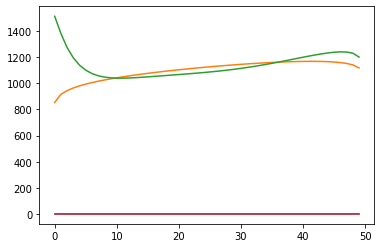

In [11]:
pd.Series(gss_v_0_guess.astype(np.float)).plot()
pd.Series(vwap_ham_solution.sum(axis = 1).astype(np.float)).plot(label = "vwap")
pd.Series(gss_ham_solution.sum(axis = 1).astype(np.float)).plot(label = "vwap")
pd.Series(v_guess.astype(np.float)).plot()

In [12]:
gss_ham_solution

array([[ 3.16993190e-03, -4.19457818e-02,  7.41845892e-01,
        -9.21463535e+00, -5.45416502e-01,  1.52279950e+03],
       [ 2.67908143e-03, -4.85343049e-02,  8.18622045e-01,
        -9.12319505e+00, -9.95598354e+00,  1.40042800e+03],
       [ 2.43333448e-03, -5.21263871e-02,  8.73390987e-01,
        -9.07889717e+00, -1.43004489e+01,  1.29676625e+03],
       [ 2.27642303e-03, -5.47352589e-02,  9.18279079e-01,
        -9.07773030e+00, -1.65862580e+01,  1.21998120e+03],
       [ 2.16451438e-03, -5.68144290e-02,  9.57424740e-01,
        -9.10771867e+00, -1.79497858e+01,  1.16552957e+03],
       [ 2.07946441e-03, -5.85561352e-02,  9.92689954e-01,
        -9.16041397e+00, -1.88803042e+01,  1.12794950e+03],
       [ 2.01212406e-03, -6.00616604e-02,  1.02508530e+00,
        -9.22994168e+00, -1.96161025e+01,  1.10279303e+03],
       [ 1.95727939e-03, -6.13914639e-02,  1.05522514e+00,
        -9.31211659e+00, -2.02811776e+01,  1.08669004e+03],
       [ 1.91169887e-03, -6.25847479e-02,  1.083

In [311]:
sum(gss_v_0_guess*X*N)

0.48432626021735276

In [316]:
def impact_f(v):
    return np.sign(v) * np.abs(v) ** delta_const

In [315]:
A = G_upper + G_diag / 2

In [317]:
def expect_cost_compute(v):
    return v @ A @ impact_f(v).T

In [280]:
expected_cost = v_guess @ A @ impact_f(v_guess).T

In [318]:
expect_cost_compute(gss_ham_solution.sum(axis = 1))

0.00010263967680164593

In [319]:
expect_cost_compute(vwap_ham_solution.sum(axis = 1))

0.00011022935917621698

In [321]:
expect_cost_compute(gss_v_0_guess * X * N)

9.703095936545951e-05

In [322]:
expect_cost_compute(v_guess * X * N)

0.00010471404520791033

In [239]:
def test_vec_f(i, j):
    if i < j:
        return i + j
    elif i > j:
        return 100
    else:
        return 0

np.fromfunction(np.vectorize(test_vec_f), (10, 10))

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
       [100,   0,   3,   4,   5,   6,   7,   8,   9,  10],
       [100, 100,   0,   5,   6,   7,   8,   9,  10,  11],
       [100, 100, 100,   0,   7,   8,   9,  10,  11,  12],
       [100, 100, 100, 100,   0,   9,  10,  11,  12,  13],
       [100, 100, 100, 100, 100,   0,  11,  12,  13,  14],
       [100, 100, 100, 100, 100, 100,   0,  13,  14,  15],
       [100, 100, 100, 100, 100, 100, 100,   0,  15,  16],
       [100, 100, 100, 100, 100, 100, 100, 100,   0,  17],
       [100, 100, 100, 100, 100, 100, 100, 100, 100,   0]])